### Q1. Install MLflow

To get started with MLflow you'll need to install the MLflow Python package.

For this we recommend creating a separate Python environment, for example, you can use conda environments, and then install the package there with pip or conda.

Once you installed the package, run the command mlflow --version and check the output.

What's the version that you have?

In [1]:
!mlflow --version 

mlflow, version 1.26.1


### Q2. Download and preprocess the data

We'll use the Green Taxi Trip Records dataset.

Download the data for January, February and March 2021 in parquet format from here.

Use the script preprocess_data.py located in the folder homework to preprocess the data.

The script will

    load the data from the folder <TAXI_DATA_FOLDER> (the folder where you have downloaded the data),
    fit a DictVectorizer on the training set (January 2021 data),
    save the preprocessed datasets and the model to disk

Your task is to download the datasets and then execute this command:

python preprocess_data.py --raw_data_path <TAXI_DATA_FOLDER> --dest_path ./output

Tip: go to 02-experiment-tracking/homework/ folder before executing the command and change the value of <TAXI_DATA_FOLDER> to the location where you saved the data.

How many files were saved to OUTPUT_FOLDER?

    1
    3
    4
    7


In [7]:
!python preprocess_data.py --raw_data_path ./data/ --dest_path ./output

In [8]:
!ls ./output/

dv.pkl	test.pkl  train.pkl  valid.pkl


### Q3. Train a model with autolog

We will train a random forest regressor (from Scikit-Learn) on the taxi dataset.

We have prepared the training script train.py for this exercise, which can be also found in the folder homework. The script will load the datasets produced by the previous step, train the model on the training set and finally calculate the RMSE on the validation set.

Your task is to modify the script to enable autologging with MLflow, execute the script and then launch the MLflow UI to check that the experiment run was properly tracked.

Tip 1: don't forget to wrap the training code with a with mlflow.start_run(): statement as we showed in the videos.

Tip 2: don't modify the hyperparameters of the model to make sure that the training will finish quickly.

How many parameters are automatically logged by MLflow?

    19
    17
    10
    20


In [6]:
!python train.py

2022/05/29 02:02:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/oleg/Projects/MLOps/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils."


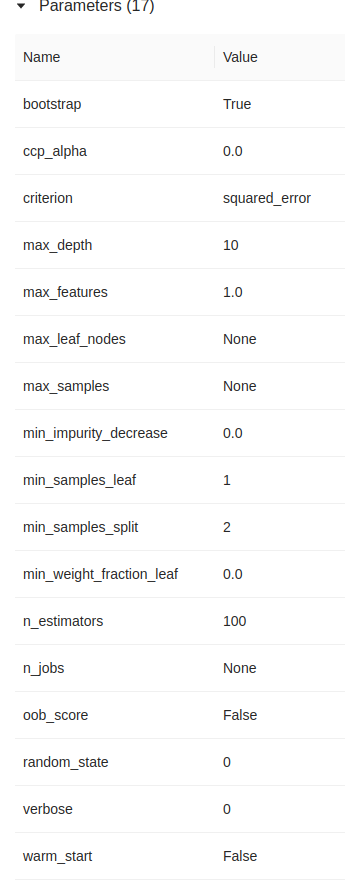

### Q4. Launch the tracking server locally

We want to manage the entire lifecycle of our ML model. In this step, you'll need to launch a tracking server. This way we will also have access to the model registry.

Your task is to

    launch the tracking server on your local machine
    select a SQLite db for the backend store and a folder called artifacts for the artifacts store

You should keep the tracking server running to work on the next two exercises that use the server.

In addition to backend-store-uri, what else do you need to pass to properly configure the server?

    default-artifact-root
    serve-artifacts
    artifacts-only
    artifacts-destination


In [2]:
!mlflow server --backend-store-uri sqlite:///mydb.sqlite --default-artifact-root ./artifacts

2022/06/02 08:10:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/06/02 08:10:35 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

### Q5. Tune the hyperparameters of the model

Now let's try to reduce the validation error by tuning the hyperparameters of the random forest regressor using hyperopt.

We have prepared the script hpo.py for this exercise.

Your task is to modify the script hpo.py and make sure that the validation RMSE is logged to MLflow for each run of the hyperparameter optimization (you will need to add a few lines of code to the objective function) and run the script without passing any parameters.

After that, open the MLflow UI and explore the runs from the experiment called random-forest-hyperopt to answer the question below.

Important: don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

    the list of hyperparameters that are passed to the objective function during the optimization.
    the RMSE obtained on the validation set (February 2021 data).

What's the best validation RMSE that you got?

    6.128
    6.628
    7.128
    7.628


In [5]:
!python hpo.py

100%|█████████| 50/50 [09:24<00:00, 11.29s/trial, best loss: 6.6284257482044735]


### Q6. Promote the best model to the model registry

The results from the hyperparameter optimization are quite good so we can assume that we are ready to test some of these models in production. In this exercise, you'll promote the best model to the model registry. We have prepared a script called register_model.py, which will check the results from the previous step and select the top 5 runs. After that, it will calculate the RMSE of those models on the test set (March 2021 data) and save the results to a new experiment called random-forest-best-models.

Your task is to update the script register_model.py so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tip 1: you can use the method search_runs from the MlflowClient to get the model with the lowest RMSE. Tip 2: to register the model you can use the method mlflow.register_model and you will need to pass the right model_uri in the form of a string that looks like this: "runs:/<RUN_ID>/model", and the name of the model (make sure to choose a good one!).

What is the test RMSE of the best model?

    6.1
    6.55
    7.93
    15.1


In [6]:
!python register_model.py

2022/06/02 08:52:52 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-best-models' does not exist. Creating a new experiment.
2022/06/02 08:53:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/oleg/Projects/MLOps/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'random-forest-best-models'.
2022/06/02 08:54:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: random-forest-best-models, version 1
Created version '1' of model 'random-forest-best-models'.


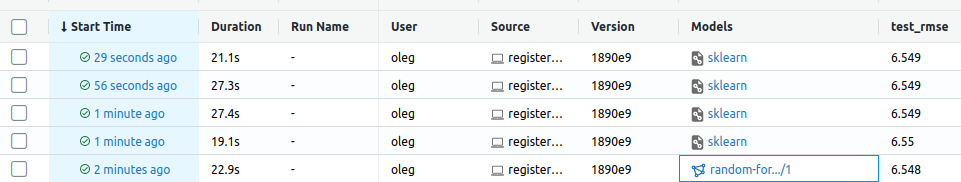